<a href="https://colab.research.google.com/github/AlexLA92/Sports-betting/blob/master/core/fuzzy_matching_prod.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

Author: Bryce Tichit (bryce@tichit.net)

This notebooks aims at matching inato marketplace sites with citeline sites for marketplace sites that do not have such a link.

As of today (6/9/2023), 23% of validated inato sites do not have an associated citeline site (column citeline_site_id). This is an issue because linking citelines sites is a crucial feature of inato products.

If a citeline link is missing for a site then,


1.   It will appear in growth listing as a new sites altough we already signed it
2.   We will not know historicals trials for this site, as we use citeline to do so.
3. We might be missing additional informations that are crucial for inato (like location data for a site)

## About this notebook

This notebooks presents an approach to build those missing links using fuzzy matching, we check every inato site against citeline database to find the most pertinent match with respect to site name.

We do not check against the full citeline database, instead we use every available information to reduce the subset of potential citeline candidates by filtering on,


*   Country (always)
*   State (when available)
*   City (when available)

[More information on Notion](https://www.notion.so/inato/Clean-growth-site-database-f361859b4d8c434ebc73a0fd1f6b26c2?pvs=4#c9e7b8a5a9744e768d6317667dad9ffa)

When building already existing citeline links this algorithm achieve a 82% accuracy. This tells us that the algorithm is pretty good for matching an inato site with citeline site when such a match exists.

However this does not tell anything about the performance of the matching against non-existing citeline sites, therefore this algorithm could match wrongly an inato site with a citeline site even when there is no corresponding match in citeline.

## Notebook output

This notebooks will apply fuzzy matching on sites that are missing a citeline link and output the result as a flat CSV file in Drive.

This can be then used to replace according BigQuery table: one_shot_growth_tmp.fuzzy_match_citeline_inato and one_shot_growth_tmp.fuzzy_match_citeline_inato_details

## Disclaimer and limits

As this methods cannot retrieve a single match with perfect accuracy and given criticity of the citeline link for inato (link cannot be wrong in product), this notebooks aims to be a one-shot approach to exclude already signed site from growth listing.

An equivalent methodology could be used to search for an ideal match instead of attributing one automatically (like in this notebook) but this will be another notebook.







In [ ]:
import pandas as pd
import numpy as np

from plotnine import *

# Authentication to connect to GDrive and BigQuery
from google.colab import auth
import gspread
from google.auth import default
#autenticating to google
auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)

%load_ext google.colab.data_table

FUZZY_MATCH_SCORE_THRESHOLD = 80
SHARED_DRIVE_NAME = '[Data] Data Analysis for Customer success team'
SHARED_DRIVE_FOLDER = 'Citeline <> Inato Fuzzy Matching'

!pip install fuzzywuzzy python-Levenshtein tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.5/172.5 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 10.3 MB/s eta 0:00:00


# Download data

In [ ]:
%%bigquery df_marketplace --project data-analysis-302917

SELECT * FROM dbt_production.dim_sites

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
%%bigquery df_citeline --project data-analysis-302917
SELECT * FROM dbt_production.dim_citeline_sites

Query is running:   0%|          |

Downloading:   0%|          |

# Preprocessing functions

In [ ]:
import re
from fuzzywuzzy import fuzz, process

def normalize_site_name(site_name):
    site_name = site_name.lower()

    site_name = re.sub(r'\s+', ' ', site_name).strip()
    site_name = re.sub(r'[,-.&]', '', site_name).strip()


    common_words = [
        "inc",
        "llc",
        "pllc",
        "dba",
        "ltd"
        ]

    regex_pattern = r'\b(?:' + '|'.join(re.escape(word) for word in common_words) + r')\b'

    site_name = re.sub(regex_pattern, '', site_name).strip()

    return site_name

us_state_mapping = {
      "AL": "Alabama",
      "AK": "Alaska",
      "AZ": "Arizona",
      "AR": "Arkansas",
      "CA": "California",
      "CO": "Colorado",
      "CT": "Connecticut",
      "DE": "Delaware",
      "FL": "Florida",
      "GA": "Georgia",
      "HI": "Hawaii",
      "ID": "Idaho",
      "IL": "Illinois",
      "IN": "Indiana",
      "IA": "Iowa",
      "KS": "Kansas",
      "KY": "Kentucky",
      "LA": "Louisiana",
      "ME": "Maine",
      "MD": "Maryland",
      "MA": "Massachusetts",
      "MI": "Michigan",
      "MN": "Minnesota",
      "MS": "Mississippi",
      "MO": "Missouri",
      "MT": "Montana",
      "NE": "Nebraska",
      "NV": "Nevada",
      "NH": "New Hampshire",
      "NJ": "New Jersey",
      "NM": "New Mexico",
      "NY": "New York",
      "NC": "North Carolina",
      "ND": "North Dakota",
      "OH": "Ohio",
      "OK": "Oklahoma",
      "OR": "Oregon",
      "PA": "Pennsylvania",
      "RI": "Rhode Island",
      "SC": "South Carolina",
      "SD": "South Dakota",
      "TN": "Tennessee",
      "TX": "Texas",
      "UT": "Utah",
      "VT": "Vermont",
      "VA": "Virginia",
      "WA": "Washington",
      "WV": "West Virginia",
      "WI": "Wisconsin",
      "WY": "Wyoming",
  }

# Preprocessing

In [ ]:
for df in (df_marketplace, df_citeline):

  df["site_name_normalized"] = df["site_name"].map(normalize_site_name)

  # replace state abbreviations for sites in the US
  # TX => Texas
  # VT => Vermont
  df["state_normalized"] = np.where(df["country_code"] == "US", df["state"].map(us_state_mapping).fillna(df["state"]), df["state"])
  df["state_normalized"] = df["state_normalized"].str.lower().str.strip()

# Dropping AI country code in inato marketplace as it seems bogus
df_marketplace = df_marketplace[df_marketplace["country_code"] != "AI"]

# Valid/Test split

Sites with a linked to a citeline site belong to the valid set. Otherwise it belongs to the test set.

Valid set is used to compare performance as we have an existing citeline link. Test set are all the sites waiting to be matched with an according citeline site

In [ ]:
COLS_INATO = ["site_id", "citeline_site_id", "country_code", "city", "state_normalized", "site_name_normalized"]
COLS_CITELINE = ["citeline_site_id", "city", "country_code", "state_normalized", "site_name_normalized"]

df_marketplace_fuzzy = df_marketplace[COLS_INATO].copy()
df_citeline_fuzzy = df_citeline[COLS_CITELINE].copy()

df_fuzzy_valid = df_marketplace_fuzzy[(df_marketplace_fuzzy["citeline_site_id"].notnull())].copy()
df_fuzzy_test = df_marketplace_fuzzy[(df_marketplace_fuzzy["citeline_site_id"].isnull())].copy()

print(f"{df_fuzzy_valid.shape[0]} inato sites have an associated citeline site")
print(f"{df_fuzzy_test.shape[0]} inato sites are missing a citeline_site_id")

8825 inato sites have an associated citeline site
4120 inato sites are missing a citeline_site_id


# Fuzzy Matching algorithm

Documentation available in Notion: https://www.notion.so/inato/Clean-growth-site-database-f361859b4d8c434ebc73a0fd1f6b26c2?pvs=4#c9e7b8a5a9744e768d6317667dad9ffa

In [ ]:
from tqdm import tqdm
import pandas as pd
import re
from fuzzywuzzy import fuzz

CITELINE_CITIES = df_citeline_fuzzy.groupby("country_code")["city"].unique().apply(set).to_dict()
CITELINE_FILTERING = True
MIN_THRESHOLD = 50
SCORER = fuzz.WRatio

KEY_INATO_MATCH = "site_name_normalized"
KEY_CITELINE_MATCH = "site_name_normalized"

def remove_words(words):
    if not words:
        return lambda x: x

    regex_pattern = r'\b(?:' + '|'.join(re.escape(word) for word in words if word) + r')\b'

    def cleaner(text):
        return re.sub(regex_pattern, '', text).strip()

    return cleaner

def build_score_dict(inato_row, citeline_row, key_inato=KEY_INATO_MATCH, key_citeline=KEY_CITELINE_MATCH, scorer=SCORER):
    score = scorer(inato_row[key_inato], getattr(citeline_row, key_citeline))

    if score <= MIN_THRESHOLD:
        return None

    return {
        f"{key_inato}_mkt": inato_row[key_inato],
        f"{key_citeline}_ctl": getattr(citeline_row, key_citeline),
        "score": score,
        "inato_site_id": inato_row.site_id,
        "citeline_site_id": citeline_row.citeline_site_id
    }

def find_best_matches(inato_row, df_citeline, **kwargs):
    """Finds best matches for a given row in another DataFrame."""
    return pd.DataFrame([x for x in (build_score_dict(inato_row, citeline_row, **kwargs) for citeline_row in df_citeline.itertuples(index=True)) if x is not None])

def fuzzy_match(inato_row, df_citeline, **kwargs):
    """Perform fuzzy match on a given inato site by finding the best corresponding
       site_name in citeline.
    """
    inato_country_code = inato_row.country_code
    df_citeline_country =  df_citeline[df_citeline["country_code"] == inato_country_code]

    match_subset_kind, df_citeline_filtered = "COUNTRY", df_citeline_country

    if CITELINE_FILTERING:
        inato_city = inato_row.city
        inato_state = inato_row.state_normalized

        if inato_city in CITELINE_CITIES.get(inato_country_code, {}):
            df_citeline_filtered =  df_citeline_country[df_citeline_country["city"] == inato_city].copy()
            match_subset_kind = "CITY"
        elif inato_state in df_citeline_country.state_normalized.unique():
            df_citeline_filtered = df_citeline_country[df_citeline_country["state_normalized"] == inato_state].copy()
            match_subset_kind = "STATE"

    if match_subset_kind != "COUNTRY":
        # Remove city and state names from the 'site_name_normalized' field when
        # performing fuzzy matching for either STATE or CITY subsets.
        # This is done to increase the accuracy of the fuzzy matching,
        # as the city or state names could be redundant or introduce noise.

        words_to_remove = [x.lower() for x in [inato_row.city, inato_row.state_normalized] if x]
        remove_fun = remove_words(words_to_remove)
        inato_row["site_name_normalized"] = remove_fun(inato_row["site_name_normalized"])
        df_citeline_filtered["site_name_normalized"] = df_citeline_filtered["site_name_normalized"].map(remove_fun)

    matches = find_best_matches(inato_row, df_citeline_filtered)
    matches["match_subset_kind"] = match_subset_kind

    return matches

def filter_best_match(df_match, top_k=5):
  """
  Helper function to extract the best match based on score.
  If multiples matches have the same score, return highest levenshtein score
  among all matches.
  """

  def compute_fuzz_ratio(r):
    """
    Calculate the levenshtein distance between citeline and inato site name
    """
    return fuzz.ratio(r[f"{KEY_INATO_MATCH}_mkt"], r[f"{KEY_CITELINE_MATCH}_ctl"])

  # Sort the DataFrame by 'score' in descending order
  df_match = df_match.sort_values("score", ascending=False)

  # Initialize and calculate ranks within each group
  df_match["rank"] = 1
  df_match["rank"] = df_match.groupby("inato_site_id")["rank"].cumsum()

  # Limit to top_k matches for each inato site
  df_match_top_k = df_match[df_match["rank"] <= top_k].copy()
  df_match_top_k["fuzz_ratio"] = df_match_top_k.apply(compute_fuzz_ratio, axis=1)

  # Find the highest score within each group
  # We can have multiple matches with same highest score
  df_match_top_k["best_score_group"] = df_match_top_k.groupby("inato_site_id")["score"].transform("max")

  # Filter to rows having the highest score within their group
  # It's possible we have ties at this point
  # If we have a tie we will return the match that has the highest fuzz_ratio
  df_match_best_score = df_match_top_k[(df_match_top_k["best_score_group"] == df_match_top_k["score"])].copy()

  # Initialize and calculate ranks based on fuzz_ratio within each high-score group
  df_match_best_score["rank_fuzzy_ratio"] = 1
  df_match_best_score["rank_fuzzy_ratio"] = df_match_best_score.groupby("inato_site_id")["rank"].cumsum()

  # Filter to the best match in each high-score group based on fuzz_ratio
  df_match_final = df_match_best_score[df_match_best_score["rank_fuzzy_ratio"] == 1].copy()

  return df_match_final

def build_mapping_fuzzy_match(df_inato, df_citeline, extract_one=True):
    """Builds a DataFrame mapping based on fuzzy matching."""

    # Perform fuzzy matching for each row in df_inato and concatenate the results
    all_dfs = [fuzzy_match(row, df_citeline) for _, row in tqdm(df_inato.iterrows(), total=df_inato.shape[0], desc="Processing", unit="row")]
    df_match = pd.concat(all_dfs)

    # If the 'extract_one' flag is True, filter the matches to the best one per inato_site_id
    if extract_one:
        df_match = filter_best_match(df_match)

    return df_match


# Run fuzzy matching on valid and assess performance

In [ ]:
df_match_valid = build_mapping_fuzzy_match(df_fuzzy_valid, df_citeline_fuzzy)

Processing: 100%|██████████| 8825/8825 [07:55<00:00, 18.56row/s]


In [ ]:
y_valid = (
    df_fuzzy_valid
    .rename(columns={"citeline_site_id": "citeline_site_id_truth"})
    .merge(df_match_valid, left_on="site_id", right_on="inato_site_id", how="left")
    .rename(columns={"citeline_site_id": "citeline_site_id_pred"})
)

y_valid["is_accurate"] = y_valid["citeline_site_id_pred"] == y_valid["citeline_site_id_truth"]

accuracy = (y_valid["is_accurate"]).mean()

print(f"Accuracy of fuzzy matching on validation: {accuracy}")

Accuracy of fuzzy matching on validation: 0.828328611898017


In [ ]:
scores = sorted(y_valid["score"].unique())

accuracy_data = []
# Loop through each quantile value
for score in scores:
    # Filter out rows where score is below the current quantile
    filtered_y_valid = y_valid[y_valid["score"] >= score]

    # Compute accuracy for this filtered dataset
    accuracy = (filtered_y_valid["citeline_site_id_pred"] == filtered_y_valid["citeline_site_id_truth"]).mean()

    n_matches = len(filtered_y_valid)
    accuracy_data.append(
        {"score": score,
         "accuracy": accuracy,
         "n_matches": n_matches,
         }
    )
df_accuracy = pd.DataFrame(accuracy_data)
df_accuracy["match_rate"] = df_accuracy["n_matches"] / len(df_match_valid)

<string>:1: FutureWarning: Allowing scalars in the Categorical constructor is deprecated and will raise in a future version.  Use `[value]` instead
<string>:1: FutureWarning: Allowing scalars in the Categorical constructor is deprecated and will raise in a future version.  Use `[value]` instead
/usr/local/lib/python3.10/dist-packages/plotnine/geoms/geom_path.py:98: PlotnineWarning: geom_path: Removed 1 rows containing missing values.
/usr/local/lib/python3.10/dist-packages/plotnine/geoms/geom_path.py:98: PlotnineWarning: geom_path: Removed 1 rows containing missing values.


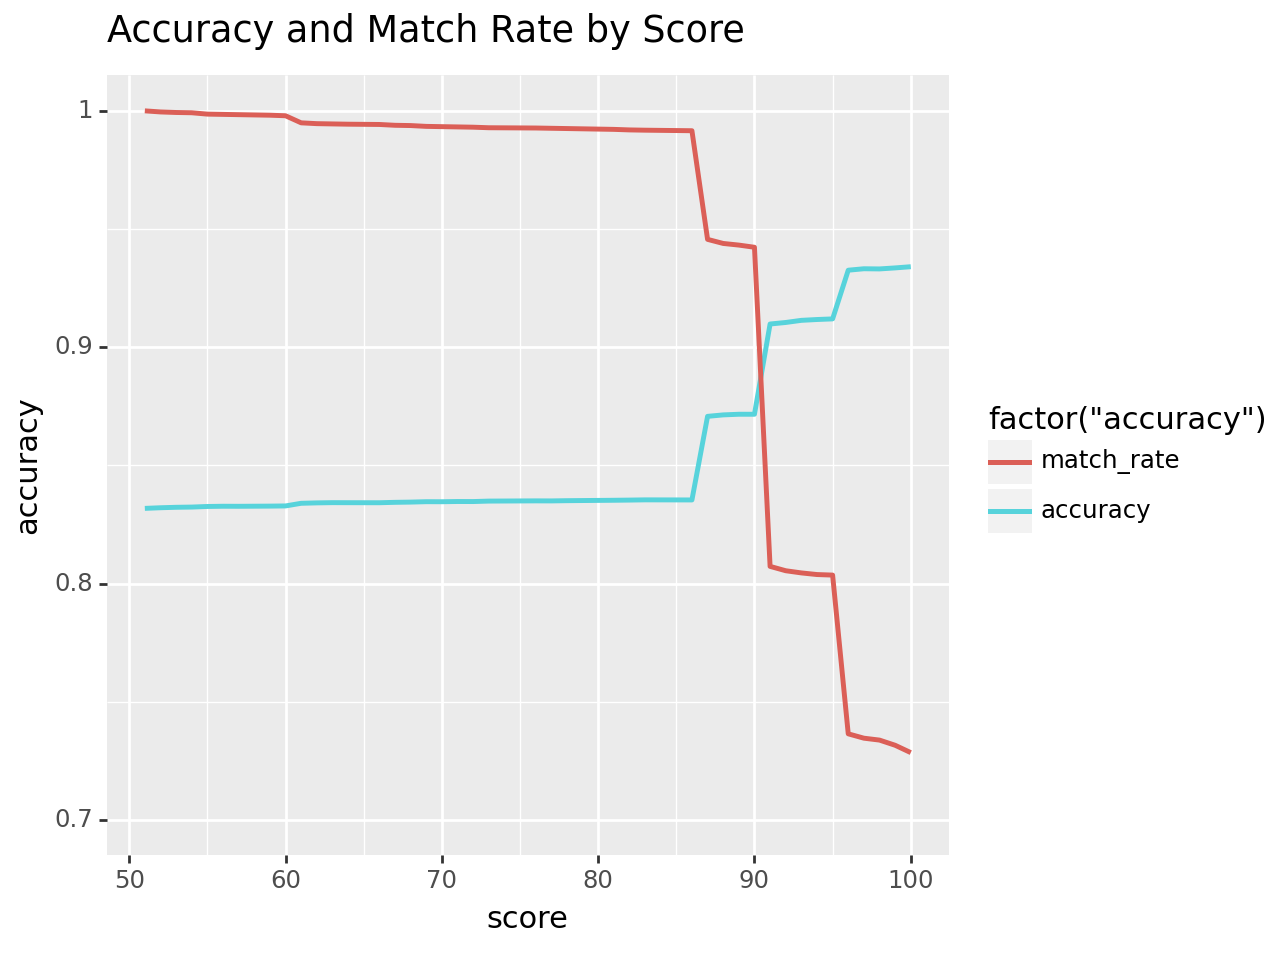

In [ ]:
p = (ggplot(df_accuracy)
     + aes(x="score", y="accuracy")
     + geom_line(aes(color='factor("accuracy")'), size=1)
     + geom_line(aes(x='score', y='match_rate', color='factor("match_rate")'), size=1)
     + ggtitle("Accuracy and Match Rate by Score")
     + ylim(0.7, 1))  # Setting min y-value to 0.6 and max y-value to 1

print(p)

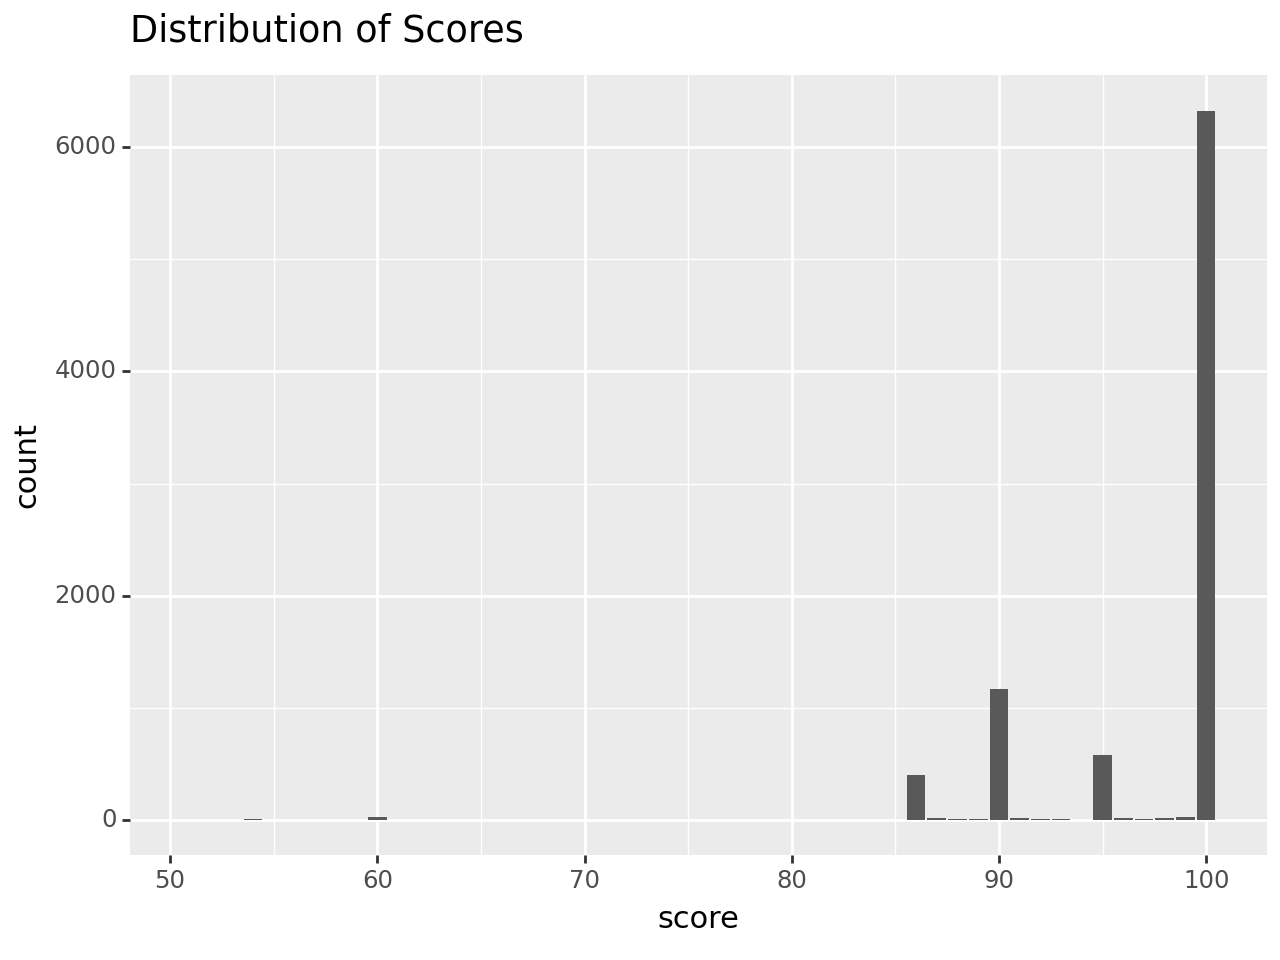

In [ ]:
p = (ggplot(df_match_valid, aes(x='score'))
     + geom_bar()
     + ggtitle("Distribution of Scores"))

print(p)

# Run fuzzy matching on inato site with missing citeline link

In [ ]:
DRY_RUN = False
SAMPLE_FRAC = .05 if DRY_RUN else 1.

df_match_test = build_mapping_fuzzy_match(df_fuzzy_test.sample(frac=SAMPLE_FRAC), df_citeline_fuzzy)
df_match_test["is_valid_match"] = df_match_test["score"] > FUZZY_MATCH_SCORE_THRESHOLD


Processing: 100%|██████████| 4068/4068 [1:26:23<00:00,  1.27s/row]


In [ ]:
print(f"found {df_match_test['is_valid_match'].sum()} valid matches ({(df_match_test['is_valid_match'].sum()/len(df_fuzzy_test)).round(2)*100} %)")

found 3335 valid matches (82.0 %)


In [ ]:
len(df_match_test)

3546

In [ ]:
df_match_test.head()

,site_name_normalized_mkt,site_name_normalized_ctl,score,inato_site_id,citeline_site_id,match_subset_kind,rank,fuzz_ratio,best_score_group,rank_fuzzy_ratio,is_valid_match
9151,south florida research center,south florida research center,100.0,a476cde0-73aa-4ae2-a6c2-8ed038cb0fd6,211378,COUNTRY,1,100,100.0,1,True
1,core clinical research,core clinical research,100.0,8e4d380b-04da-4796-979d-07bb73aab590,242171,CITY,1,100,100.0,1,True
11,medical care and research sa de cv,medical care and research sa de cv,100.0,8994931a-3178-4e3b-a7a9-048976f9acbe,134013,CITY,1,100,100.0,1,True
9,city bone joint clinic (kcbj),city bone joint clinic (kcbj),100.0,af2611c9-3f14-4752-aade-a51f0d5231a3,82004,CITY,1,100,100.0,1,True
606,rheumatology center of houston,rheumatology center of houston,100.0,2b027ac5-b087-4f0b-93aa-9c723eb2ea58,220831,STATE,1,100,100.0,1,True


In [ ]:
df_citeline_match = df_match_test[df_match_test["is_valid_match"]].groupby('citeline_site_id').apply(lambda x: list(zip(x['inato_site_id'], x['score']))).reset_index(name='fuzzy_matched_with')


In [ ]:
df_citeline_match.head()

,citeline_site_id,fuzzy_matched_with
0,100009,"[(2eb98e84-8e70-4291-b9f8-370c37873cb9, 100.0)]"
1,100010,"[(f8c0b160-a728-4c55-abf1-ad231799a5d9, 86.0)]"
2,100037,"[(00f05b72-3a8a-4905-b8d6-41906b1865bb, 95.0)]"
3,10016,"[(b38cc090-1b87-4e8f-8c5b-00dff7e592e8, 90.0)]"
4,100189,"[(b47dfd38-0565-4600-803c-0bacf764a8b8, 95.0)]"


In [ ]:
(df_match_test["score"] == 100).mean()

0.218556119571348

In [ ]:
df_match_test["is_perfect"] = df_match_test["score"] == 100

In [ ]:
df_match_test.groupby("match_subset_kind")["is_perfect"].mean()

match_subset_kind
CITY       0.237895
COUNTRY    0.189672
STATE      0.115854
Name: is_perfect, dtype: float64

In [ ]:
COLS_INATO_FUZZY_MATCH = ['site_name_normalized_mkt', 'site_name_normalized_ctl', 'score',
       'inato_site_id', 'citeline_site_id', 'match_subset_kind', 'fuzz_ratio']

table_inato_citeline_fuzzy_match_details = df_match_test[df_match_test["is_valid_match"]][COLS_INATO_FUZZY_MATCH]
table_inato_citeline_fuzzy_match = df_citeline_match[["citeline_site_id", "fuzzy_matched_with"]]

In [ ]:
df_citeline_match.head()

NameError: ignored

# Upload fuzzy match result onto shared drive

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive
Fuzzy match output saved in shared drive in [Data] Data Analysis for Customer success team/Citeline <> Inato Fuzzy Matching


In [ ]:
if DRY_RUN:
  raise ValueError("Cannot upload fuzzy matching to Google Drive when DRY_RUN flag is enabled. Disable it and rerun fuzzy matching")

# Save DataFrames to CSV files in the shared drive
table_inato_citeline_fuzzy_match_details.to_csv(f'/content/drive/Shared drives/{SHARED_DRIVE_NAME}/{SHARED_DRIVE_FOLDER}/table_inato_citeline_fuzzy_match_details.csv', index=False)
table_inato_citeline_fuzzy_match.to_csv(f'/content/drive/Shared drives/{SHARED_DRIVE_NAME}/{SHARED_DRIVE_FOLDER}/table_inato_citeline_fuzzy_match.csv', index=False)

print(f"Fuzzy match output saved in shared drive in {SHARED_DRIVE_NAME}/{SHARED_DRIVE_FOLDER}")


Fuzzy match output saved in shared drive in [Data] Data Analysis for Customer success team/Citeline <> Inato Fuzzy Matching
